# Описание задачи

В данном блокноте я попробую воспроизвести цикл обучения модели FROMAGE на примере подготовленного на  предыдущих шагах семплинга датасета. Весь код взят из репозитория авторов https://github.com/kohjingyu/fromage и немного упрощен, чтобы можно было запускать в одном ноутбуке. Для запуска нужны библиотеки, указанные в файле requirements в репозитории авторов. При этом окружение с этими библиотеками я не устанавливала, так как пользовалась Yandex DataSphere и все библиотеки в нем уже есть. В коде добавдены только те, которых не было и они понадобились, так как я еще и использовала свои данные для обучения.



# 1. Подготовка данных

Семплинг данных из датасета CC3M уже подготовлен мною в предыдущем ноутбуке и загружен в Datasphere. Подгружу и посмотрю эти данные. Билиотеки все установлены из клона github авторов.

In [1]:
#!g2.1
%pip install -q -U einops datasets matplotlib tqdm boto3 git+https://github.com/dask/s3fs

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
#!g2.1
from datasets import load_from_disk
reloaded_encoded_dataset = load_from_disk("filtered.hf")
reloaded_encoded_dataset

Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 372
})

Посмотрим датасет и залогинюсь на Hugging Face, чтобы не было проблем со скачиванием некоторых элементов модели (почему-то иногда без логина не скачаиются в datasphere, хотя локально таких проблем нет)

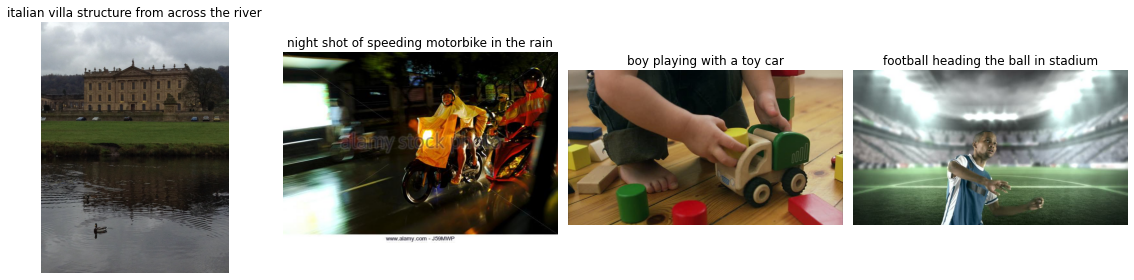

In [3]:
#!g2.1
import matplotlib.pyplot as plt
import random

num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_item = random.choice(reloaded_encoded_dataset)
    axs[i].imshow(random_item["image"])
    title = random_item["caption"]
    title = title.strip()
    axs[i].set_title(title)
    axs[i].set_axis_off()
fig.tight_layout()
fig.show()

In [4]:
#!g2.1
%pip install -q transformers

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
#!g2.1
%pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

In [6]:
#!g2.1
from huggingface_hub import notebook_login
notebook_login()

Загрузим чек-пойнт модели CLIP для обработки изображений. Я возьму такой же, как и авторы статьи. Далее будет функция, которая будет извлекать информацию из изображений и формировать матрицу размером (3, 224, 224)


In [7]:
#!g2.1
from transformers import AutoFeatureExtractor
visual_encoder = 'openai/clip-vit-large-patch14'
feature_extractor = AutoFeatureExtractor.from_pretrained(visual_encoder, train = False)

2023-11-09 11:45:26.802211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [8]:
#!g2.1
def get_pixel_values_for_model(feature_extractor, img):
      pixel_values = feature_extractor(img.convert('RGB'),
        return_tensors="pt").pixel_values[0, ...]  # (3, H, W)
      return pixel_values

In [9]:
#!g2.1
get_pixel_values_for_model(feature_extractor, reloaded_encoded_dataset[50]['image']).shape

torch.Size([3, 224, 224])

Следующая функция меняет размеры вектора текста, чтобы он соответсвовал вектору изображения. Эта функция будет использована в качестве вспомогательной при формирвоании обучающего датасета.


In [10]:
#!g2.1
import torch
from torchvision.transforms import functional as F
def create_image_of_text(text: str, width: int = 224, nrows: int = 2, color=(255, 255, 255), font=None) -> torch.Tensor:
      """Creates a (3, nrows * 14, width) image of text.

      Returns:
        cap_img: (3, 14 * nrows, width) image of wrapped text.
      """
      height = 12
      padding = 5
      effective_width = width - 2 * padding
      # Create a black image to draw text on.
      cap_img = Image.new('RGB', (effective_width * nrows, height), color = (0, 0, 0))
      draw = ImageDraw.Draw(cap_img)
      draw.text((0, 0), text, color, font=font or ImageFont.load_default())
      cap_img = F.convert_image_dtype(F.pil_to_tensor(cap_img), torch.float32)  # (3, height, W * nrows)
      cap_img = torch.split(cap_img, effective_width, dim=-1)  # List of nrow elements of shape (3, height, W)
      cap_img = torch.cat(cap_img, dim=1)  # (3, height * nrows, W)
      # Add zero padding.
      cap_img = torch.nn.functional.pad(cap_img, [padding, padding, 0, padding])
      return cap_img

Далее авторы предлагают создать кастомный датасет, в результате которого будут получены векторы и текстового описания, и изображения в одинаковом размере, что позволит их собирать в один вектор для обучения линейного слоя. Использовать это класс нужно после инициализации модели и включение в текстовый токенайзер нового токена для дополнительного срецсимвола [RET], иначе не будет совпадать размерность векторов в обучающей выборке и модели.


In [11]:
#!g2.1
from torch.utils.data import Dataset
from PIL import Image, ImageFont, ImageDraw, ImageOps

class CsvDataset(Dataset):
      def __init__(self, tokenizer, image_list,
                   caption_list, feature_extractor,
                   max_len: int = 32, precision: str = 'fp32',
                   image_size: int = 224, retrieval_token_idx: int = -1):
        self.image_list = [image for image in image_list]
        self.caption_list = [caption for caption in caption_list]
        assert len(self.image_list) == len(self.caption_list)
        self.feature_extractor = feature_extractor
        self.image_size = image_size
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.precision = precision
        self.retrieval_token_idx = retrieval_token_idx
        self.font = None


      def __len__(self):
        return len(self.caption_list)

      def __getitem__(self, idx):
            
            image = get_pixel_values_for_model(self.feature_extractor, self.image_list[idx])
            caption = str(self.caption_list[idx])
            caption += '[RET]'
            tokenized_data = self.tokenizer(
              caption,
              return_tensors="pt",
              padding='max_length',
              truncation=True,
              max_length=self.max_len)
            tokens = tokenized_data.input_ids[0]

            caption_len = tokenized_data.attention_mask[0].sum()

            decode_caption = self.tokenizer.decode(tokens, skip_special_tokens=False)
            self.font = self.font or ImageFont.load_default()
            cap_img = create_image_of_text(decode_caption, width=self.image_size, nrows=2, font=self.font)

            if tokens[-1] not in [self.retrieval_token_idx, self.tokenizer.pad_token_id]:
              tokens[-1] = self.retrieval_token_idx

            return image, cap_img, tokens, caption_len

# 2. Собираем модель

В качестве основы модели авторы используют LLM из семейства OPT. ДЛя обучения они использовали модель на 6,7 миллиарда параметров, я возьму самую маленькую - всего на 125 млн. для экономии места и ресурсов. 


In [12]:
#!g2.1
from transformers import AutoTokenizer
opt_version = 'facebook/opt-125m'
tokenizer = AutoTokenizer.from_pretrained(opt_version, use_fast=False)

Выбираем аргументы модели и собираем их в класс FrozenArgs. В качестве значений аргументов я беру дефолтные значения, которые указали авторы в статье.
- freeze_lm: bool = True - заморозка языковой модели
- freeze_vm: bool = True - заморозка визуального энкодера
- opt_version: str = 'facebook/opt-125m' - используемая версия/чек пойнт языковой модели
- visual_encoder: str = 'openai/clip-vit-large-patch14'- используемая версия/чек пойнт визуального энкодера
- n_visual_tokens: int = 1 - кол-во визуальных токенов в линейном связующем слое между LLM и визуального энкодера
- image_embed_dropout_prob: float = 0.0 параметр для аугментации данных (периодически подается только текст без изображения при обучении), не буду использовать поэтому 0
- task: str = 'captioning' - дефолтный режим модели на обучение image captioning, в обучении будем переключаться между 2-мя режимами
- shared_emb_dim: Optional[int] = 256
- text_emb_layers: List[int] = [-1] 
- retrieval_token_idx: int = 0 - - дефолтный токен для нового знака [RET], потом заменю при инициализации модели и датасета
- text_embed_dropout_prob: float = 0.0 - параметр для аугментации данных (периодически подается только изображение без текста при обучении), не буду использовать поэтому 0


In [13]:
#!g2.1
from typing import Callable, List, Optional, Tuple, Union

class FrozenArgs:
      freeze_lm: bool = True
      freeze_vm: bool = True
      opt_version: str = 'facebook/opt-125m'
      visual_encoder: str = 'openai/clip-vit-large-patch14'
      n_visual_tokens: int = 1
      image_embed_dropout_prob: float = 0.0
      task: str = 'captioning'
      shared_emb_dim: Optional[int] = 256
      text_emb_layers: List[int] = [-1]
      retrieval_token_idx: int = 0
      text_embed_dropout_prob: float = 0.0

Далее создадим дополнительные функции, которые будут включены в метод класса модели для генерации ответов на инференсе (метод generate_for_images_and_texts): одна йункция будет работать с промптами, другая выгружать картинки по url


In [14]:
#!g2.1
def truncate_caption(caption: str) -> str:
  """Truncate captions at periods and newlines."""
  caption = caption.strip('\n')
  trunc_index = caption.find('\n') + 1
  if trunc_index <= 0:
      trunc_index = caption.find('.') + 1
  if trunc_index > 0:
    caption = caption[:trunc_index]
  return caption

In [15]:
#!g2.1
def get_image_from_url(url: str):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    img = img.convert('RGB')
    return img

Теперь создаются 2 класса для модели с параметрами слоев и методов. Код практически без изменений из репозитория авторов, только удалили несколько методов, которые не использую и немного поменяла для работы в одном ноутбуке.


In [16]:
#!g2.1
import torch.nn as nn

class FromageModel(nn.Module):
    
      def __init__(self, tokenizer, args: FrozenArgs = FrozenArgs()):
        super().__init__()
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.image_token = self.tokenizer.cls_token_id
        assert args.text_emb_layers != set(args.text_emb_layers), 'text_emb_layers not unique'
        self.args = args

        opt_version = args.opt_version
        visual_encoder = args.visual_encoder
        n_visual_tokens = args.n_visual_tokens
        print(f"Using {opt_version} for the language model.")
        print(f"Using {visual_encoder} for the visual model with {n_visual_tokens} visual tokens.")

        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.lm = OPTForCausalLM.from_pretrained(opt_version)
        self.opt_version = opt_version

        if self.args.freeze_lm:
          self.lm.eval()
          print("Freezing the LM.")
          for param in self.lm.parameters():
            param.requires_grad = False
        else:
          self.lm.train()


        # NOTE: Resizing sets all token embeddings and all lm_head weights (since they are tied in OPT)
        # to be trainable (param.requires_grad = True).
        self.retrieval_token_idx = args.retrieval_token_idx
        print(f'Initializing embedding for the retrieval token [RET] (id = {self.retrieval_token_idx}).')
        self.lm.resize_token_embeddings(len(tokenizer))

        self.input_embeddings = self.lm.get_input_embeddings()

        print("Restoring pretrained weights for the visual model.")

        self.visual_model = CLIPVisionModel.from_pretrained(visual_encoder)
        hidden_size = self.visual_model.config.hidden_size

        if self.args.freeze_vm:
          print("Freezing the VM.")
          self.visual_model.eval()
          for param in self.visual_model.parameters():
            param.requires_grad = False
        else:
          self.visual_model.train()

        self.visual_model_name = visual_encoder

        embedding_dim = self.input_embeddings.embedding_dim * self.args.n_visual_tokens
        self.text_hidden_fcs = nn.ModuleList([])
        if self.args.shared_emb_dim is None:
          if len(self.args.text_emb_layers) == 1:
            if (self.args.text_emb_layers[0] in [-1, self.lm.config.num_hidden_layers]) and ('bert' not in opt_version):
              out_dim = self.lm.config.word_embed_proj_dim
            else:
              out_dim = self.lm.config.hidden_size
          else:
            if (-1 in self.args.text_emb_layers) or (self.lm.config.num_hidden_layers in self.args.text_emb_layers) \
              and (self.lm.config.word_embed_proj_dim != self.lm.config.hidden_size):
              raise ValueError('No projection dim specified but model uses last output layer and an intermediate one (which have different dims).')
            else:
              out_dim = self.lm.config.hidden_size
        else:
          out_dim = self.args.shared_emb_dim

          for layer_idx in self.args.text_emb_layers:
            if (layer_idx == -1 or layer_idx == self.lm.config.num_hidden_layers) and ('bert' not in opt_version):
              in_dim = self.lm.config.word_embed_proj_dim

              text_fc = [nn.Linear(in_dim, out_dim), nn.Dropout(self.args.text_embed_dropout_prob)]
              self.text_hidden_fcs.append(nn.Sequential(*text_fc))

            elif layer_idx < self.lm.config.num_hidden_layers:
              text_fc = [nn.Linear(self.lm.config.hidden_size, out_dim), nn.Dropout(self.args.text_embed_dropout_prob)]
              self.text_hidden_fcs.append(nn.Sequential(*text_fc))
            else:
              raise ValueError(f'Embedding of layer {layer_idx} was requested but model only has {self.lm.config.num_hidden_layers} layers.')

        self.visual_embeddings = nn.Linear(hidden_size, embedding_dim)
        self.visual_fc = nn.Linear(hidden_size, out_dim)

        self.image_dropout = nn.Dropout(self.args.image_embed_dropout_prob)
    
      def get_visual_embs(self, pixel_values: torch.FloatTensor, mode: str = 'captioning'):
        if mode not in ['captioning', 'retrieval']:
          raise ValueError(f'mode should be one of ["caption", "retrieval"], got {mode} instead.')

        # Extract visual embeddings from the vision encoder.
        outputs = self.visual_model(pixel_values)
        encoder_outputs = outputs.pooler_output

        # Use the correct fc based on function argument.
        if mode == 'captioning':
          visual_embs = self.visual_embeddings(encoder_outputs)  # (2, D * n_visual_tokens)
          visual_embs = torch.reshape(visual_embs, (visual_embs.shape[0], self.args.n_visual_tokens, -1))
        elif mode == 'retrieval':
          visual_embs = self.visual_fc(encoder_outputs)  # (2, D * n_visual_tokens)
          visual_embs = torch.reshape(visual_embs, (visual_embs.shape[0], 1, -1))
        else:
          raise NotImplementedError

        visual_embs = self.image_dropout(visual_embs)
        return visual_embs
    
      def train(self, mode=True):
        super(FromageModel, self).train(mode=mode)
        # Overwrite train() to ensure Frozen models remain frozen.
        if self.args.freeze_lm:
          self.lm.eval()
        if self.args.freeze_vm:
          self.visual_model.eval()
        
      def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: torch.LongTensor,
        caption_len: torch.LongTensor,
        mode: str = 'captioning',
        concat_captions: bool = False,
        input_prefix: Optional[str] = None,
        inference: bool = False,
      ):
        visual_embs = self.get_visual_embs(pixel_values, mode)

        batch_size, vis_seq_len, _ = visual_embs.shape  # vis_seq_len = n_visual_tokens
        if labels is not None:
          assert labels.shape[0] == batch_size, (visual_embs.shape, labels.shape)

        input_embs = self.input_embeddings(labels)  # (N, T, D)

        last_embedding_idx = caption_len - 1  # -1 to retrieve the token before the eos token

        if input_prefix is not None:
          prompt_ids = self.tokenizer(input_prefix, add_special_tokens=False, return_tensors="pt").input_ids
          prompt_ids = prompt_ids.to(visual_embs.device)
          prompt_embs = self.input_embeddings(prompt_ids)
          prompt_embs = prompt_embs.repeat(batch_size, 1, 1)
          assert prompt_embs.shape[0] == batch_size, prompt_embs.shape
          assert prompt_embs.shape[2] == input_embs.shape[2], prompt_embs.shape
          assert len(prompt_embs.shape) == 3, prompt_embs.shape

        if mode == 'captioning':
          # Concat to text embeddings.
          condition_seq_len = 0
          if input_prefix is None:
            # Just add visual embeddings.
            input_embs = torch.cat([visual_embs, input_embs], axis=1)
            last_embedding_idx += vis_seq_len
            condition_seq_len += vis_seq_len
            full_labels = torch.zeros(visual_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100
          else:
            # Add visual and prompt embeddings.
            prefix_embs = torch.cat([visual_embs, prompt_embs], axis=1)
            input_embs = torch.cat([prefix_embs, input_embs], axis=1)

            last_embedding_idx += prefix_embs.shape[1]
            condition_seq_len += prefix_embs.shape[1]
            full_labels = torch.zeros(prefix_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100

          # Mask out embedding tokens in the labels.
          full_labels = torch.cat([full_labels, labels], axis=1)

          pad_idx = []

          for label in full_labels:
            for k, token in enumerate(label):
              # Mask out retrieval token if it exists.
              if token in [self.tokenizer.pad_token_id, self.retrieval_token_idx]:
                label[k:] = -100
                pad_idx.append(k)
                break
              if k == len(label) - 1:  # No padding found.
                pad_idx.append(k + 1)
          assert len(pad_idx) == batch_size, (len(pad_idx), batch_size)

          bs, seq_len, embs_dim = input_embs.shape
          if concat_captions:
            assert len(input_embs.shape) == 3, input_embs
            assert len(full_labels.shape) == 2, full_labels
            assert batch_size % 2 == 0
            all_concat_input_embs = []
            all_concat_labels = []

            # Rearrange embeddings and labels (and their padding) to concatenate captions.
            for i in range(batch_size // 2):
              first_idx = i * 2
              second_idx = first_idx + 1
              first_emb = input_embs[first_idx, :pad_idx[first_idx], :]
              first_labels = full_labels[first_idx, :pad_idx[first_idx]]
              first_padding = input_embs[first_idx, pad_idx[first_idx]:, :]
              first_labels_padding = full_labels[first_idx, pad_idx[first_idx]:]

              second_emb = input_embs[second_idx, :pad_idx[second_idx], :]
              second_labels = full_labels[second_idx, :pad_idx[second_idx]]
              second_padding = input_embs[second_idx, pad_idx[second_idx]:, :]
              second_labels_padding = full_labels[second_idx, pad_idx[second_idx]:]

              assert torch.all(first_labels_padding == -100), first_labels_padding
              assert torch.all(second_labels_padding == -100), second_labels_padding
              concat_input_embs = torch.cat([first_emb, second_emb, first_padding, second_padding], axis=0)   # (T*2, 768)
              concat_labels = torch.cat([first_labels, second_labels, first_labels_padding, second_labels_padding], axis=0)   # (T*2, 768)
              all_concat_input_embs.append(concat_input_embs)
              all_concat_labels.append(concat_labels)

            # Pad to max length.
            input_embs = torch.stack(all_concat_input_embs, axis=0)  # (N/2, T*2, 768)
            full_labels = torch.stack(all_concat_labels, axis=0)  # (N/2, T*2, 768)
            assert input_embs.shape == (bs // 2, seq_len * 2, embs_dim), input_embs.shape
            assert full_labels.shape == (bs // 2, seq_len * 2), full_labels.shape

          output = self.lm(inputs_embeds=input_embs,
                           labels=full_labels,
                           output_hidden_states=True)
        elif mode == 'retrieval':
          full_labels = torch.clone(labels)
          if input_prefix is not None:
            print(f'Adding prefix "{input_prefix}" to retrieval.')
            # Add prompt embeddings.
            prefix_embs = prompt_embs
            input_embs = torch.cat([prefix_embs, input_embs], axis=1)
            last_embedding_idx += prefix_embs.shape[1]
            full_labels = torch.cat([
              torch.zeros(prefix_embs.shape[:2], dtype=torch.int64).to(labels.device) - 100,
              full_labels
            ], axis=1)

          pad_idx = []
          for label in full_labels:
            for k, token in enumerate(label):
              if token == self.tokenizer.pad_token_id:
                label[k:] = -100
                pad_idx.append(k)
                break
              if k == len(label) - 1:  # No padding found.
                pad_idx.append(k + 1)
          assert len(pad_idx) == batch_size, (len(pad_idx), batch_size)

          output = self.lm(inputs_embeds=input_embs,
                           labels=full_labels,
                           output_hidden_states=True)
        else:
          raise NotImplementedError

        last_embedding = None
        last_output_logit = None
        hidden_states = []

        if mode == 'retrieval':
          if self.args.shared_emb_dim is not None:
            for idx, fc_layer in zip(self.args.text_emb_layers, self.text_hidden_fcs):
              hidden_states.append(fc_layer(output.hidden_states[idx]))  # (N, seq_len, 2048)
          else:
            for idx in self.args.text_emb_layers:
              hidden_states.append(output.hidden_states[idx])

          # Add hidden states together.
          last_hidden_state = torch.stack(hidden_states, dim=-1).sum(dim=-1)

          if not concat_captions:
            last_embedding = torch.stack([last_hidden_state[i, last_embedding_idx[i], :] for i in range(batch_size)], axis=0)  # (N, D)
            last_output_logit = torch.stack([output.logits[i, last_embedding_idx[i] - 1, :] for i in range(batch_size)], axis=0)  # (N, D)
          else:
            raise NotImplementedError

          # Compute retrieval loss.
          assert visual_embs.shape[1] == 1, visual_embs.shape
          visual_embs = visual_embs[:, 0, :]
          visual_embs = visual_embs / visual_embs.norm(dim=1, keepdim=True)
          last_embedding = last_embedding / last_embedding.norm(dim=1, keepdim=True)

          # cosine similarity as logits
          logit_scale = self.logit_scale.exp()
          visual_embs = logit_scale * visual_embs
        elif mode == 'captioning':
          pass
        else:
          raise NotImplementedError

        return output, full_labels, last_embedding, last_output_logit, visual_embs
    
      def generate(self, embeddings = torch.FloatTensor, max_len: int = 32,
               temperature: float = 0.0, top_p: float = 1.0, min_word_tokens: int = 0,
               ret_scale_factor: float = 1.0, filter_value: float = -float('Inf')):
        """Runs greedy decoding and returns generated captions.

        Args:
          embeddings: Input condition that the model uses for autoregressive generation.
          max_len: Maximum number of tokens to generate.
          temperature: Used to modulate logit distribution.
          top_p: If set to < 1, the smallest set of tokens with highest probabilities that add up to top_p or higher are kept for generation.
          min_word_tokens: Minimum number of words to generate before allowing a [RET] output.
          ret_scale_factor: Proportion to scale [RET] token logits by. A higher value may increase the probability of the model generating [RET] outputs.
          filter_value: Value to assign to tokens that should never be generated.
        Outputs:
          out: (N, T) int32 sequence of output tokens.
          output_embeddings: (N, T, 256) sequence of text output embeddings.
        """
        self.lm.eval()

        with torch.no_grad():  # no tracking history
          batch_size, s, _ = embeddings.shape
          # init output with image tokens
          out = None
          past_key_values = None
          output_embeddings = []
          output_logits = []

          for i in range(max_len):
            if 'opt' in self.opt_version:
              output = self.lm(inputs_embeds=embeddings, use_cache=False, output_hidden_states=True)
            else:
              if i == 0:
                output = self.lm(inputs_embeds=embeddings, use_cache=True, past_key_values=None, output_hidden_states=True)
              else:
                output = self.lm(input_ids=out[:, -1:], use_cache=True, past_key_values=past_key_values, output_hidden_states=True)

            # Collect and sum the hidden states.
            hidden_states = []
            if self.args.shared_emb_dim is not None:
              for idx, fc_layer in zip(self.args.text_emb_layers, self.text_hidden_fcs):
                hidden_states.append(fc_layer(output.hidden_states[idx]))  # (N, seq_len, 2048)
            else:
              for idx in self.args.text_emb_layers:
                hidden_states.append(output.hidden_states[idx])
            # Add hidden states together.
            last_hidden_state = torch.stack(hidden_states, dim=-1).sum(dim=-1)  # (N, T, 256)
            last_embedding = last_hidden_state / last_hidden_state.norm(dim=-1, keepdim=True)
            output_embeddings.append(last_embedding)

            logits = output.logits[:, -1, :]  # (N, vocab_size)
            if top_p == 1.0:
              logits = logits.cpu()
            output_logits.append(logits)

            if self.retrieval_token_idx != -1 and self.retrieval_token_idx is not None:
              if i < min_word_tokens:
                # Eliminate probability of generating [RET] if this is earlier than min_word_tokens.
                logits[:, self.retrieval_token_idx] = filter_value
              else:
                # Multiply by scaling factor.
                logits[:, self.retrieval_token_idx] = logits[:, self.retrieval_token_idx] * ret_scale_factor

            past_key_values = output.past_key_values

            if temperature == 0.0:
              if top_p != 1.0:
                raise ValueError('top_p cannot be set if temperature is 0 (greedy decoding).')
              next_token = torch.argmax(logits, keepdim=True, dim=-1)  # (N, 1)
            else:
              logits = logits / temperature

              # Apply top-p filtering.
              if top_p < 1.0:
                assert top_p > 0, f'top_p should be above 0, got {top_p} instead.'
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)  # (N, D) and (N, D)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1) # (N, D)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift the indices to the right to keep also the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                for j in range(sorted_indices.shape[0]):
                  indices_to_remove = sorted_indices[j, sorted_indices_to_remove[j, :]]
                  logits[j, indices_to_remove] = filter_value

              token_weights = logits.exp()   # (N, vocab_size)
              next_token = torch.multinomial(token_weights, 1)  # (N, 1)

            next_token = next_token.long().to(embeddings.device)
            if out is not None:
              out = torch.cat([out, next_token], dim=-1)
            else:
              out = next_token

            if 'opt' in self.opt_version:
              next_embedding = self.input_embeddings(next_token)
              embeddings = torch.cat([embeddings, next_embedding], dim=1)
            elif (self.tokenizer.eos_token_id and (next_token == self.tokenizer.eos_token_id).all()):
              # End of generation.
              break

        return out, output_embeddings, output_logits


In [17]:
#!g2.1
from torch import Tensor
from collections import namedtuple
class Fromage(nn.Module):
  def __init__(self, tokenizer, model_args: Optional[FrozenArgs] = None,
               path_array: Optional[List[str]] = None, emb_matrix: Optional[torch.tensor] = None):
    super().__init__()
    self.model = FromageModel(tokenizer, model_args)
    self.path_array = path_array
    self.emb_matrix = emb_matrix

  def __call__(self, images: Tensor, tgt_tokens: Optional[Tensor] = None, caption_len: Optional[Tensor] = None,
               generate: bool = False, num_words: int = 32, temperature: float = 1.0, top_p: float = 1.0,
               ret_scale_factor: float = 1.0, min_word_tokens: int = 0,
               mode: str = 'captioning', concat_captions: bool = False,
               input_prefix: Optional[str] = None, inference: bool = False) -> Tensor:
    if generate:
      return self.model.generate(images, num_words, temperature=temperature, top_p=top_p,
                                 min_word_tokens=min_word_tokens, ret_scale_factor=ret_scale_factor)
    else:
      output = self.model(
        pixel_values = images,
        labels = tgt_tokens,
        caption_len = caption_len,
        mode = mode,
        concat_captions = concat_captions,
        input_prefix = input_prefix,
        inference = inference)
      return output

  def generate_for_images_and_texts(
    self, prompts: List, num_words: int = 0, ret_scale_factor: float = 1.0, top_p: float = 1.0, temperature: float = 0.0,
    max_num_rets: int = 1, max_img_per_ret: int = 1):
    """
    Encode prompts into embeddings.

    Args:
      prompts: List of interleaved PIL.Image.Image and strings representing input to the model.
      num_words: Maximum number of words to generate for. If num_words = 0, the model will run its forward pass and return the outputs.
      ret_scale_factor: Proportion to scale [RET] token logits by. A higher value may increase the probability of the model generating [RET] outputs.
      top_p: If set to < 1, the smallest set of tokens with highest probabilities that add up to top_p or higher are kept for generation.
      temperature: Used to modulate logit distribution.
      max_num_rets: Maximum number of images to return in one generation pass.
      max_img_per_ret: Maximum number of images to return for each [RET] token.
    Returns:
      return_outputs: List consisting of either str or List[PIL.Image.Image] objects, representing image-text interleaved model outputs.
    """
    input_embs = []
    input_ids = []
    add_bos = True

    for i, p in enumerate(prompts):
      if type(p) == Image.Image:
        # Encode as image.
        pixel_values = get_pixel_values_for_model(self.model.feature_extractor, p)
        pixel_values = pixel_values.to(device=self.model.logit_scale.device, dtype=self.model.logit_scale.dtype)
        pixel_values = pixel_values[None, ...]

        visual_embs = self.model.get_visual_embs(pixel_values, mode='captioning')  # (1, n_visual_tokens, D)
        input_embs.append(visual_embs)
      elif type(p) == str:
        text_ids = self.model.tokenizer(p, add_special_tokens=True, return_tensors="pt").input_ids.to(self.model.logit_scale.device)
        if not add_bos:
          # Remove <bos> tag.
          text_ids = text_ids[:, 1:]
        else:
          # Only add <bos> once.
          add_bos = False

        text_embs = self.model.input_embeddings(text_ids)  # (1, T, D)
        input_embs.append(text_embs)
        input_ids.append(text_ids)
      else:
        raise ValueError(f'Input prompts should be either PIL.Image.Image or str types, got {type(p)} instead.')
    input_embs = torch.cat(input_embs, dim=1)
    input_ids = torch.cat(input_ids, dim=1)

    if num_words == 0:
      generated_ids = input_ids
      outputs = self.model.lm(inputs_embeds=input_embs, use_cache=False, output_hidden_states=True)
      # Map outputs to embeddings, so we can retrieve embeddings from the [RET] tokens.
      out = []
      for x, fc in zip(self.model.args.text_emb_layers, self.model.text_hidden_fcs):
          out.append(fc(outputs.hidden_states[x]))
      embeddings = torch.stack(out, dim=-1).sum(dim=-1)
      embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)  # (N, T, 256)
    elif num_words > 0:
      generated_ids, generated_embeddings, _ = self.model.generate(input_embs, num_words,
        temperature=temperature, top_p=top_p, ret_scale_factor=ret_scale_factor)
      embeddings = generated_embeddings[-1][:, input_embs.shape[1]:]

      # Truncate to newline.
      newline_token_id = self.model.tokenizer('\n', add_special_tokens=False).input_ids[0]
      trunc_idx = 0
      for j in range(generated_ids.shape[1]):
        if generated_ids[0, j] == newline_token_id:
          trunc_idx = j
          break
      if trunc_idx > 0:
        generated_ids = generated_ids[:, :trunc_idx]
        embeddings = embeddings[:, :trunc_idx]
    else:
      raise ValueError

    # Save outputs as an interleaved list.
    return_outputs = []
    # Find up to max_num_rets [RET] tokens, and their corresponding scores.
    all_ret_idx = [i for i, x in enumerate(generated_ids[0, :] == self.model.retrieval_token_idx) if x][:max_num_rets]
    seen_image_idx = []  # Avoid showing the same image multiple times.

    last_ret_idx = 0
    if len(all_ret_idx) == 0:
      # No [RET] tokens.
      caption = self.model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
      return_outputs.append(truncate_caption(caption))
    else:
      for ret_idx in all_ret_idx:
        ret_emb = embeddings[:, ret_idx, :]

        scores = self.emb_matrix @ ret_emb.T

        # Downweight seen images.
        for seen_idx in seen_image_idx:
          scores[seen_idx, :] -= 1000

        # Get the top max_img_per_ret + 3 (in case some fail) images for each image.
        _, top_image_idx = scores.squeeze().topk(max_img_per_ret + 3)
        image_outputs = []
        for img_idx in top_image_idx:
          # Find the first image that does not error out.
          try:
            seen_image_idx.append(img_idx)
            img =reloaded_encoded_dataset['image'][img_idx]
            image_outputs.append(img)
            if len(image_outputs) == max_img_per_ret:
              break
          except UnidentifiedImageError:
            pass

        caption = self.model.tokenizer.batch_decode(generated_ids[:, last_ret_idx:ret_idx], skip_special_tokens=True)[0]
        last_ret_idx = ret_idx + 1
        return_outputs.append(truncate_caption(caption) + ' [RET]')
        return_outputs.append(image_outputs)

    return return_outputs

  def get_log_lik_scores(
    self, prompts: List):
    """
    Output the log likelihoods of the given interleaved prompts.

    Args:
      prompts: List of interleaved PIL.Image.Image and strings representing input to the model.
    Returns:
      log lik score of prompt sequence.
    """
    input_embs = []
    input_ids = []
    add_bos = True

    for i, p in enumerate(prompts):
      if type(p) == Image.Image:
        # Encode as image.
        pixel_values = get_pixel_values_for_model(self.model.feature_extractor, p)
        pixel_values = pixel_values.to(device=self.model.logit_scale.device, dtype=self.model.logit_scale.dtype)
        pixel_values = pixel_values[None, ...]

        visual_embs = self.model.get_visual_embs(pixel_values, mode='captioning')  # (1, n_visual_tokens, D)
        input_embs.append(visual_embs)
        id_ = torch.zeros(visual_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100
        input_ids.append(id_)
      elif type(p) == str:
        text_ids = self.model.tokenizer(p, add_special_tokens=True, return_tensors="pt").input_ids.to(self.model.logit_scale.device)
        if not add_bos:
          # Remove <bos> tag.
          text_ids = text_ids[:, 1:]
        else:
          # Only add <bos> once.
          add_bos = False

        text_embs = self.model.input_embeddings(text_ids)  # (1, T, D)
        input_embs.append(text_embs)
        input_ids.append(text_ids)
      else:
        raise ValueError(f'Input prompts should be either PIL.Image.Image or str types, got {type(p)} instead.')
    input_embs = torch.cat(input_embs, dim=1)
    input_ids = torch.cat(input_ids, dim=1)

    outputs = self.model.lm(inputs_embeds=input_embs, labels=input_ids, use_cache=False, output_hidden_states=True)
    return -outputs.loss.item()  


In [18]:
#!g2.1
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
#!g2.1
# Create model
model_args = FrozenArgs()

Здесь как раз добавляем дополнительный токен и вносим его в аргументы для уже инициализированной модели. Ниже показываю, что этот токен появился в аргументах модели.

In [20]:
#!g2.1
# Add an image token for loss masking (and visualization) purposes.
tokenizer.add_special_tokens({"cls_token": "<|image|>"})  # add special image token to tokenizer
print('Adding [RET] token to vocabulary.')
print('Before adding new token, tokenizer("[RET]") =', tokenizer('[RET]', add_special_tokens=False))
num_added_tokens = tokenizer.add_tokens('[RET]')
print(f'After adding {num_added_tokens} new tokens, tokenizer("[RET]") =', tokenizer('[RET]', add_special_tokens=False))
ret_token_idx = tokenizer('[RET]', add_special_tokens=False).input_ids
assert len(ret_token_idx) == 1, ret_token_idx
model_args.retrieval_token_idx = ret_token_idx[0]

Adding [RET] token to vocabulary.
Before adding new token, tokenizer("[RET]") = {'input_ids': [10975, 36995, 742], 'attention_mask': [1, 1, 1]}
After adding 1 new tokens, tokenizer("[RET]") = {'input_ids': [50266], 'attention_mask': [1]}


In [21]:
#!g2.1
model_args.retrieval_token_idx

50266

Итак, токен есть в аргументах модели, можно теперь создадть датасет для обучения с использованием объявленного ранее класса. Как видно, размрености векторов для изображения и текста совпадают, что позволит их конкатенировать при обучении модели. Также привожу пример, как в итоге выглядят тензоры в обучающей выборке. Интересно, что токен [RET] уже в тензоре, хотя авторы в статье про это детально не писали (50266)!

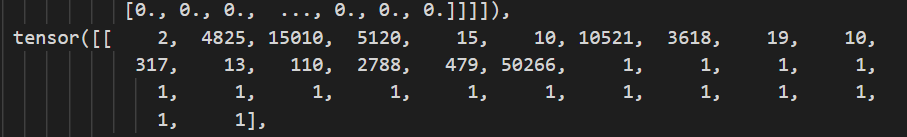


In [22]:
#!g2.1
train_dataset =  CsvDataset(
        tokenizer = tokenizer,
        image_list = reloaded_encoded_dataset['image'],
        caption_list = reloaded_encoded_dataset['caption'],
        feature_extractor = feature_extractor,
        retrieval_token_idx = model_args.retrieval_token_idx
)
example = train_dataset[0]

print(len(example))
for i in example:
    print(i.shape)
    
batch_size = 8

train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size)

next(iter(train_loader))

4
torch.Size([3, 224, 224])
torch.Size([3, 29, 224])
torch.Size([32])
torch.Size([])


[tensor([[[[-1.1353, -1.1353, -1.1353,  ..., -1.1353, -1.1353, -1.1207],
           [-1.1353, -1.1353, -1.1353,  ..., -1.1353, -1.1353, -1.1207],
           [-1.1353, -1.1353, -1.1353,  ..., -1.1353, -1.1353, -1.1207],
           ...,
           [ 1.9157,  1.9157,  1.9157,  ...,  1.9157,  1.9157,  1.9157],
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303]],
 
          [[-1.0767, -1.0767, -1.0767,  ..., -1.0767, -1.0767, -1.0617],
           [-1.0767, -1.0767, -1.0767,  ..., -1.0767, -1.0767, -1.0617],
           [-1.0767, -1.0767, -1.0767,  ..., -1.0767, -1.0767, -1.0617],
           ...,
           [ 2.0599,  2.0599,  2.0599,  ...,  2.0599,  2.0599,  2.0599],
           [ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749],
           [ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749]],
 
          [[-0.8403, -0.8403, -0.8403,  ..., -0.8403, -0.8403, -0.8261],
           [-

In [23]:
#!g2.1
from transformers import AutoConfig, AutoModel, AutoModelForCausalLM
from transformers import OPTForCausalLM, GPT2Tokenizer
from transformers import CLIPVisionModel, CLIPVisionConfig

Наконец инициализируем саму модель!!! Перенесем ее на GPU и посмотрим архитектуру


In [24]:
#!g2.1
import numpy as np
model = Fromage(tokenizer, model_args)

Using facebook/opt-125m for the language model.
Using openai/clip-vit-large-patch14 for the visual model with 1 visual tokens.


Freezing the LM.
Initializing embedding for the retrieval token [RET] (id = 50266).
Restoring pretrained weights for the visual model.


Freezing the VM.


In [25]:
#!g2.1
model = model.bfloat16()

In [26]:
#!g2.1
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
#!g2.1
model.to(device)

Fromage(
  (model): FromageModel(
    (lm): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50267, 768)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-11): 12 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (activation_fn): ReLU()
              (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(

# Обучение модели

Зададим параметра для обучения - я немного поменяла предложенные авторами, чтобы опять же использовать меньше ресурсов. Наверное они в целом стандартные для циклов обучения, кроме 

- concat_captions_prob = 0.5 - параметр, с помощью которого авторы как раз предлагают бороться с переобучением модели на генерацию текста в ущерб изображению. Я взяла параметр как предлагали авторы.
- concat_for_ret = False - этот параметр отключает вариат с конкатенацией выше в случае если модель выаолняет обучение в режиме image retrieval

In [28]:
#!g2.1
n_epochs = 6
steps_per_epoch = 2000
lr = 0.0003
lr_schedule_step_size = 10
lr_schedule_gamma = 0.1
batch_size = 16
lr_warmup_steps = 100
concat_captions_prob = 0.5
concat_for_ret = False
cap_loss_scale = 1
ret_loss_scale = 1
grad_accumulation_steps = 1
grad_clip = 1.0
print_freq = 10

Далее стандартно задаем optimizer + scheduler, и Loss для задачи предсказания следующего токена. 

In [29]:
#!g2.1
criterion = nn.CrossEntropyLoss().to(device)
optimizer_cls = torch.optim.AdamW

optimizer = optimizer_cls(model.parameters(), lr)

In [30]:
#!g2.1
%pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-fs9ll8ro
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-fs9ll8ro
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [31]:
#!g2.1
from torch.optim.lr_scheduler import StepLR
from warmup_scheduler import GradualWarmupScheduler

scheduler_steplr = StepLR(optimizer, step_size=lr_schedule_step_size * steps_per_epoch, gamma=lr_schedule_gamma)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1.0, total_epoch=lr_warmup_steps, after_scheduler=scheduler_steplr)

Несколько вспомогательных функций для реализации выводы результатов в процессе обучения. В том числе и функции для расчета метрик

In [32]:
#!g2.1
class ProgressMeter(object):
  def __init__(self, num_batches, meters, prefix=""):
    self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
    self.meters = meters
    self.prefix = prefix

  def display(self, batch):
    entries = [self.prefix + self.batch_fmtstr.format(batch)]
    entries += [str(meter) for meter in self.meters]
    print('\t'.join(entries))
    
  def display_summary(self):
    entries = [" *"]
    entries += [meter.summary() for meter in self.meters]
    print(' '.join(entries))

  def _get_batch_fmtstr(self, num_batches):
    num_digits = len(str(num_batches // 1))
    fmt = '{:' + str(num_digits) + 'd}'
    return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [33]:
#!g2.1
def accuracy(output, target, padding, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  with torch.no_grad():
    maxk = max(topk)
    if output.shape[-1] < maxk:
      print(f"[WARNING] Less than {maxk} predictions available. Using {output.shape[-1]} for topk.")

    maxk = min(maxk, output.shape[-1])
    batch_size = target.size(0)

    # Take topk along the last dimension.
    _, pred = output.topk(maxk, -1, True, True)  # (N, T, topk)

    mask = (target != padding).type(target.dtype)
    target_expand = target[..., None].expand_as(pred)
    correct = pred.eq(target_expand)
    correct = correct * mask[..., None].expand_as(correct)

    res = []
    for k in topk:
      correct_k = correct[..., :k].reshape(-1).float().sum(0, keepdim=True)
      res.append(correct_k.mul_(100.0 / mask.sum()))
    return res

In [34]:
#!g2.1
import time
from enum import Enum
import torchvision

In [35]:
#!g2.1
class Summary(Enum):
  NONE = 0
  AVERAGE = 1
  SUM = 2
  COUNT = 3

In [36]:
#!g2.1
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
    self.name = name
    self.fmt = fmt
    self.summary_type = summary_type
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

  def all_reduce(self):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    total = torch.tensor([self.sum, self.count], dtype=torch.float32, device=device)
    dist.all_reduce(total, dist.ReduceOp.SUM, async_op=False)
    self.sum, self.count = total.tolist()
    self.avg = self.sum / self.count

  def __str__(self):
    fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
    return fmtstr.format(**self.__dict__)
  
  def summary(self):
    fmtstr = ''
    if self.summary_type is Summary.NONE:
      fmtstr = ''
    elif self.summary_type is Summary.AVERAGE:
      fmtstr = '{name} {avg:.3f}'
    elif self.summary_type is Summary.SUM:
      fmtstr = '{name} {sum:.3f}'
    elif self.summary_type is Summary.COUNT:
      fmtstr = '{name} {count:.3f}'
    else:
      raise ValueError('invalid summary type %r' % self.summary_type)
    
    return fmtstr.format(**self.__dict__)

В качестве основной метрики при image retrieval авторы используют контрастный Loss + accuracy. Функции ниже для расчета этих метрик.

In [37]:
#!g2.1
from typing import Optional
import torch


def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
  return torch.nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))


def contrastive_acc(logits: torch.Tensor, target: Optional[torch.Tensor] = None, topk=(1,)) -> torch.Tensor:
  """
  Args:
    logits: (N, N) predictions.
    target: (N, num_correct_answers) labels.
  """
  assert len(logits.shape) == 2, logits.shape
  batch_size = logits.shape[0]

  if target is None:
    target = torch.arange(len(logits), device=logits.device)
    return accuracy(logits, target, -1, topk)
  else:
    assert len(target.shape) == 2, target.shape
    with torch.no_grad():
      maxk = max(topk)
      if logits.shape[-1] < maxk:
        print(f"[WARNING] Less than {maxk} predictions available. Using {logits.shape[-1]} for topk.")
      maxk = min(maxk, logits.shape[-1])

      # Take topk along the last dimension.
      _, pred = logits.topk(maxk, -1, True, True)  # (N, topk)
      assert pred.shape == (batch_size, maxk)

      target_expand = target[:, :, None].repeat(1, 1, maxk)  # (N, num_correct_answers, topk)
      pred_expand = pred[:, None, :].repeat(1, target.shape[1], 1)  # (N, num_correct_answers, topk)
      correct = pred_expand.eq(target_expand)  # (N, num_correct_answers, topk)
      correct = torch.any(correct, dim=1)  # (N, topk)

      res = []
      for k in topk:
        any_k_correct = torch.clamp(correct[:, :k].sum(1), max=1)  # (N,)
        correct_k = any_k_correct.float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
      return res

Наконец, основная функция для обучения. Здесь видно как батч из обучающей выборки проходит последовательно через 2 задача на Image captioning + Image retrieval и собирает итоговый loss как сумму Loss на каждом этапе

In [38]:
#!g2.1
def train(train_loader, model, tokenizer, criterion, optimizer, epoch, scheduler):
  """Main training loop."""

  batch_time = AverageMeter('Time', ':6.3f')
  cap_time = AverageMeter('CaptioningTime', ':6.3f')
  ret_time = AverageMeter('RetrievalTime', ':6.3f')
  data_time = AverageMeter('Data', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  ce_losses = AverageMeter('CeLoss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')
  cont_losses = AverageMeter('ContLoss', ':.4e')
  top1_caption = AverageMeter('AccCaption@1', ':6.2f')
  top5_caption = AverageMeter('AccCaption@5', ':6.2f')
  top1_image = AverageMeter('AccImage@1', ':6.2f')
  top5_image = AverageMeter('AccImage@5', ':6.2f')

  progress = ProgressMeter(
    steps_per_epoch,
    [batch_time, losses, ce_losses, cont_losses, top1, top5],
    prefix="Epoch: [{}]".format(epoch))

  # switch to train mode
  model.train()

  end = time.time()

  for i, (images, caption_images, tgt_tokens, token_len) in enumerate(train_loader):
    actual_step = epoch * steps_per_epoch + i + 1
    # measure data loading time
    data_time.update(time.time() - end)

    images = images.to(device)
    tgt_tokens = tgt_tokens.to(device)
    token_len = token_len.to(device)
    images = images.bfloat16()

    model_modes = ['captioning', 'retrieval']
    loss = 0

    for model_mode in model_modes:
      mode_start = time.time()
      # compute output
      concat_captions = np.random.uniform(0, 1) < concat_captions_prob
      if not concat_for_ret:
        concat_captions = concat_captions and model_mode == 'captioning'

      (model_output, full_labels, last_embedding, _, visual_embs) = model(
        images, tgt_tokens, token_len, mode=model_mode, concat_captions=concat_captions, inference=False)
      output = model_output.logits

      # Measure captioning accuracy for multi-task models and next-token prediction for retrieval models.
      if model_mode == 'captioning':
        acc1, acc5 = accuracy(output[:, :-1, :], full_labels[:, 1:], -100, topk=(1, 5))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

      ce_loss = model_output.loss
      if model_mode == 'captioning':
        ce_loss = ce_loss * cap_loss_scale
      elif model_mode == 'retrieval':
        ce_loss = ce_loss * ret_loss_scale
      else:
        raise NotImplementedError

      loss += ce_loss
      ce_losses.update(ce_loss.item(), images.size(0))

      if model_mode == 'retrieval':
        # Cross replica concat for embeddings.

        logits_per_image = visual_embs @ last_embedding.t()
        logits_per_text = logits_per_image.t()
        if i == 0:
          print(f'Running contrastive loss over logits_per_text.shape = {logits_per_text.shape} and logits_per_image.shape = {logits_per_image.shape}')

        # Compute contrastive losses for retrieval.
        caption_loss = contrastive_loss(logits_per_text)
        image_loss = contrastive_loss(logits_per_image)
        caption_acc1, caption_acc5 = contrastive_acc(logits_per_text, topk=(1, 5))
        image_acc1, image_acc5 = contrastive_acc(logits_per_image, topk=(1, 5))
        loss += ret_loss_scale * (caption_loss + image_loss) / 2.0
        cont_losses.update(loss.item(), images.size(0))

        # measure accuracy and record loss
        top1_caption.update(caption_acc1[0], images.size(0))
        top5_caption.update(caption_acc5[0], images.size(0))
        top1_image.update(image_acc1[0], images.size(0))
        top5_image.update(image_acc5[0], images.size(0))

      if model_mode == 'retrieval':
        ret_time.update(time.time() - mode_start)
      elif model_mode == 'captioning':
        cap_time.update(time.time() - mode_start)

    loss = loss / grad_accumulation_steps
    losses.update(loss.item(), images.size(0))
    loss.backward()

    # Update weights
    if ((i + 1) % grad_accumulation_steps == 0) or (i == steps_per_epoch - 1):
      # Zero out gradients of the embedding matrix outside of [RET].
      for param in model.model.input_embeddings.parameters():
        assert param.grad.shape[0] == len(tokenizer)
        # Keep other embeddings frozen.
        mask = torch.arange(param.grad.shape[0]) != model_args.retrieval_token_idx
        param.grad[mask, :] = 0

      # compute gradient and do SGD step
      if grad_clip > 0:
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()

    with torch.no_grad():
      # Normalize trainable embeddings.
      frozen_norm = torch.norm(model.model.input_embeddings.weight[:-1, :], dim=1).mean(0)
      trainable_weight = model.model.input_embeddings.weight[-1, :]
      model.model.input_embeddings.weight[-1, :].div_(torch.norm(trainable_weight) / frozen_norm)

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

    if actual_step == 1 or (i + 1) % print_freq == 0:
      ex_per_sec = batch_size / batch_time.avg

      progress.display(i + 1)

      image_bs = images.shape[0]
      normalized_images = images - images.min()
      normalized_images /= normalized_images.max()  # (N, 3, H, W)
      max_images_to_show = 16

      # Append caption text.
      pred_tokens = output[:, model_args.n_visual_tokens-1:-1, :].argmax(dim=-1)
      generated_captions = tokenizer.batch_decode(pred_tokens, skip_special_tokens=False)

      batch_time.reset()
      cap_time.reset()
      ret_time.reset()
      data_time.reset()
      losses.reset()
      ce_losses.reset()
      top1.reset()
      top5.reset()
      cont_losses.reset()
      top1_caption.reset()
      top5_caption.reset()
      top1_image.reset()
      top5_image.reset()

    if i == steps_per_epoch - 1:
      break

    scheduler.step()
    curr_lr = scheduler.get_last_lr()


Запускаю обучение, сделаю 6 эпох, но с кол-вом степов я переборщила, надо было брать не больше кол-ва позиций в обучающей выборке

In [39]:
#!g2.1
for i in range(n_epochs):
    train(train_loader, model, tokenizer, criterion, optimizer, i, scheduler)

Running contrastive loss over logits_per_text.shape = torch.Size([8, 8]) and logits_per_image.shape = torch.Size([8, 8])
Epoch: [0][   1/2000]	Time  1.453 ( 1.453)	Loss 1.3000e+01 (1.3000e+01)	CeLoss 5.6562e+00 (5.3281e+00)	ContLoss 1.3000e+01 (1.3000e+01)	Acc@1  22.22 ( 22.22)	Acc@5  36.75 ( 36.75)
Epoch: [0][  10/2000]	Time  0.268 ( 0.268)	Loss 1.4750e+01 (1.5299e+01)	CeLoss 6.5312e+00 (6.5087e+00)	ContLoss 1.4750e+01 (1.5299e+01)	Acc@1  10.71 ( 12.77)	Acc@5  28.57 ( 27.29)
Epoch: [0][  20/2000]	Time  0.270 ( 0.297)	Loss 1.4500e+01 (1.4762e+01)	CeLoss 6.5938e+00 (6.2219e+00)	ContLoss 1.4500e+01 (1.4762e+01)	Acc@1  14.71 ( 14.40)	Acc@5  28.43 ( 30.42)
Epoch: [0][  30/2000]	Time  0.233 ( 0.249)	Loss 1.5125e+01 (1.5150e+01)	CeLoss 6.9062e+00 (6.4906e+00)	ContLoss 1.5125e+01 (1.5150e+01)	Acc@1  12.24 ( 14.47)	Acc@5  25.51 ( 27.16)
Epoch: [0][  40/2000]	Time  0.244 ( 0.247)	Loss 1.5438e+01 (1.5250e+01)	CeLoss 7.1562e+00 (6.5062e+00)	ContLoss 1.5438e+01 (1.5250e+01)	Acc@1  14.12 ( 13.54)	A

# Инференс (попытка :)

Добавлю подготовленные ранее визуальные эмбедингы (мой cheat ход), так как моя недообученная модель с ними не справится, а проверить инференс хочется.

In [40]:
#!g2.1
import pickle as pkl

emb_matrix = []
with open("sample_emb.pkl", "rb") as wf:
    train_embs_data = pkl.load(wf)
    emb_matrix.append(train_embs_data["embeddings"])
emb_matrix = torch.stack([item for item in emb_matrix[0]])

logit_scale = model.model.logit_scale.exp()
emb_matrix = torch.tensor(emb_matrix.clone().detach(), dtype=logit_scale.dtype).to(logit_scale.device)
emb_matrix = emb_matrix / emb_matrix.norm(dim=1, keepdim=True)
emb_matrix = logit_scale * emb_matrix
model.emb_matrix = emb_matrix
emb_matrix.shape

<ipython-input-40-33103b4792a4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb_matrix = torch.tensor(emb_matrix.clone().detach(), dtype=logit_scale.dtype).to(logit_scale.device)


torch.Size([372, 256])

Добавлю функция, предложенные авторами для инференса и попробую те же самые запросы, что я делала с полноценной и обученной авторами моделью.

In [41]:
#!g2.1
import numpy as np
import copy
import torch
from transformers import logging
logging.set_verbosity_error()

from PIL import Image
%pip install matplotlib
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [42]:
#!g2.1

def trunc_caption(caption: str) -> str:
    # Truncate at period.
    trunc_index = caption.find('.') + 1
    if trunc_index < 0:
        trunc_index = caption.find('\n') + 1
    caption = caption[:trunc_index]
    return caption

def display_interleaved_outputs(model_outputs, one_img_per_ret=True):
    for output in model_outputs:
        if type(output) == str:
            print(output)
        elif type(output) == list:
            if one_img_per_ret:
                plt.figure(figsize=(3, 3))
                plt.imshow(np.array(output[0]))
            else:
                fig, ax = plt.subplots(1, len(output), figsize=(3 * len(output), 3))
                for i, image in enumerate(output):
                    image = np.array(image)
                    ax[i].imshow(image)
                    ax[i].set_title(f'Retrieval #{i+1}')
            plt.show()
        elif type(output) == Image.Image:
            plt.figure(figsize=(3, 3))
            plt.imshow(np.array(output))
            plt.show()

Prompt:


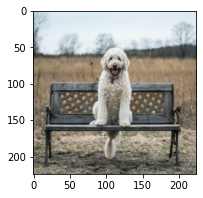

watercolor drawing [RET]
Model generated outputs:
watercolor drawing  [RET]


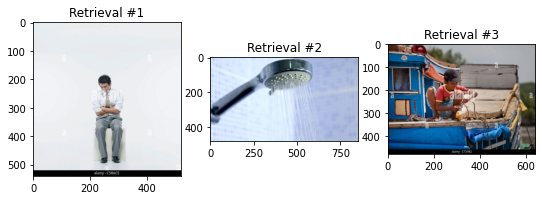

Prompt:


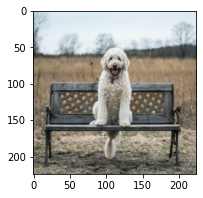

vector icon [RET]
Model generated outputs:
vector icon  [RET]


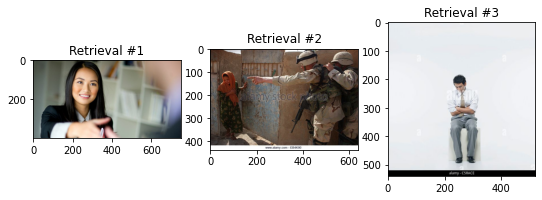

In [43]:
#!g2.1
import requests
from io import BytesIO

inp_image =get_image_from_url('https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png')

# Get FROMAGe to retrieve images of cats in other styles.
for inp_text in ['watercolor drawing [RET]', 'vector icon [RET]']:
    prompt = [inp_image, inp_text]
    print('Prompt:')
    display_interleaved_outputs(prompt)
    print('=' * 30)
    model_outputs = model.generate_for_images_and_texts(prompt, max_img_per_ret=3)

    # Display outputs.
    print('Model generated outputs:')
    display_interleaved_outputs(model_outputs, one_img_per_ret=False)

Получилось конечно так себе, хотя если притягивать за уши - сидящий человек и сидящая собака! Кол-во картинок 500 шт конечно очень мало и модель, которая не генерирует и подбирает картинки вряд ли может лучше сработать.

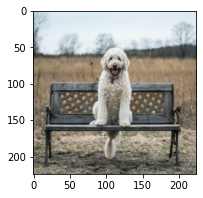

Input:     What is this?
FROMAGe:   A woman who is a member of the family, and who is a member of the family.
Input:     Where would this look good in?
FROMAGe:   A woman who is a member of the family, and who is a member of the family.


In [44]:
#!g2.1
#!g2.1
ret_scale_factor = 1.15  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = get_image_from_url(
    'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this?",
    "Where would this look good in?"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'
    
    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

Диалого не удался, вылез недостаток языковой модели, которая начинается повторяться. 



# Финальные выводы
Обучающая выборка определенно мала и каких-то внятных результатов достичь не получилось. Интересно было посмотреть детально код и попробовать его повторить. Если судить по динамике loss + accuracy, модель все-таки пыталась учиться и метрики улучшались. 